In [1]:
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-white')
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In [3]:
import pickle
df=pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
#df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
681501,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",843.0,lot42270,25.0,[[Test]],[[none]],"(35, 31)"
719047,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1256.0,lot43791,17.0,[[Test]],[[none]],"(41, 40)"
600450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37733,9.0,[],[],"(49, 39)"
437445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot26448,17.0,[],[],"(35, 40)"
631481,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot39737,8.0,[],[],"(25, 27)"


In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
tol_wafers = df.shape[0]

In [8]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [9]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)",8,0
...,...,...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[],"(26, 30)",[],[]


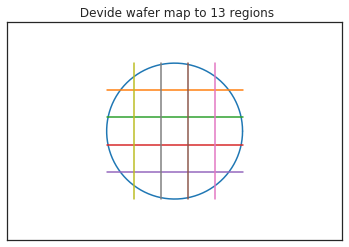

In [10]:
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
from matplotlib import pyplot as plt
import numpy as np

def cal_den1(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions1(x):
    rows=np.size(x,axis=0)
    rows = rows/2
    cols=np.size(x,axis=1)
    cols = cols/2
    ind3 = np.arange(rows/2+cols/2, (2 * np.pi*np.sqrt(1/2*(rows*rows + cols*cols))),rows//10)
    ind3 = ind3.astype('int')
    reg1 = x[ind3[0]:ind3[1]]
    reg2 = x[ind3[1]:ind3[2]]
    reg3 = x[ind3[2]:ind3[3]]
    reg4 = x[ind3[3]:ind3[4]]
    reg5 = x[ind3[4]:ind3[5]]                 
    reg6 = x[ind3[5]:ind3[6]]                 
    reg7 = x[ind3[6]:ind3[7]]                 
    reg8 = x[ind3[7]:ind3[8]]                 
    reg9 = x[ind3[8]:ind3[9]]                  
             
    fea_reg_den1 = []
    fea_reg_den1 = [cal_den1(reg1),cal_den1(reg2),cal_den1(reg3),cal_den1(reg4),cal_den1(reg5),cal_den1(reg6),cal_den1(reg7),cal_den1(reg8),cal_den1(reg9)]
    
    return fea_reg_den1

df_withpattern['fea_cir'] = df_withpattern.waferMap.apply(find_regions1)

In [12]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)

   
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]


    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den




In [13]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

In [14]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

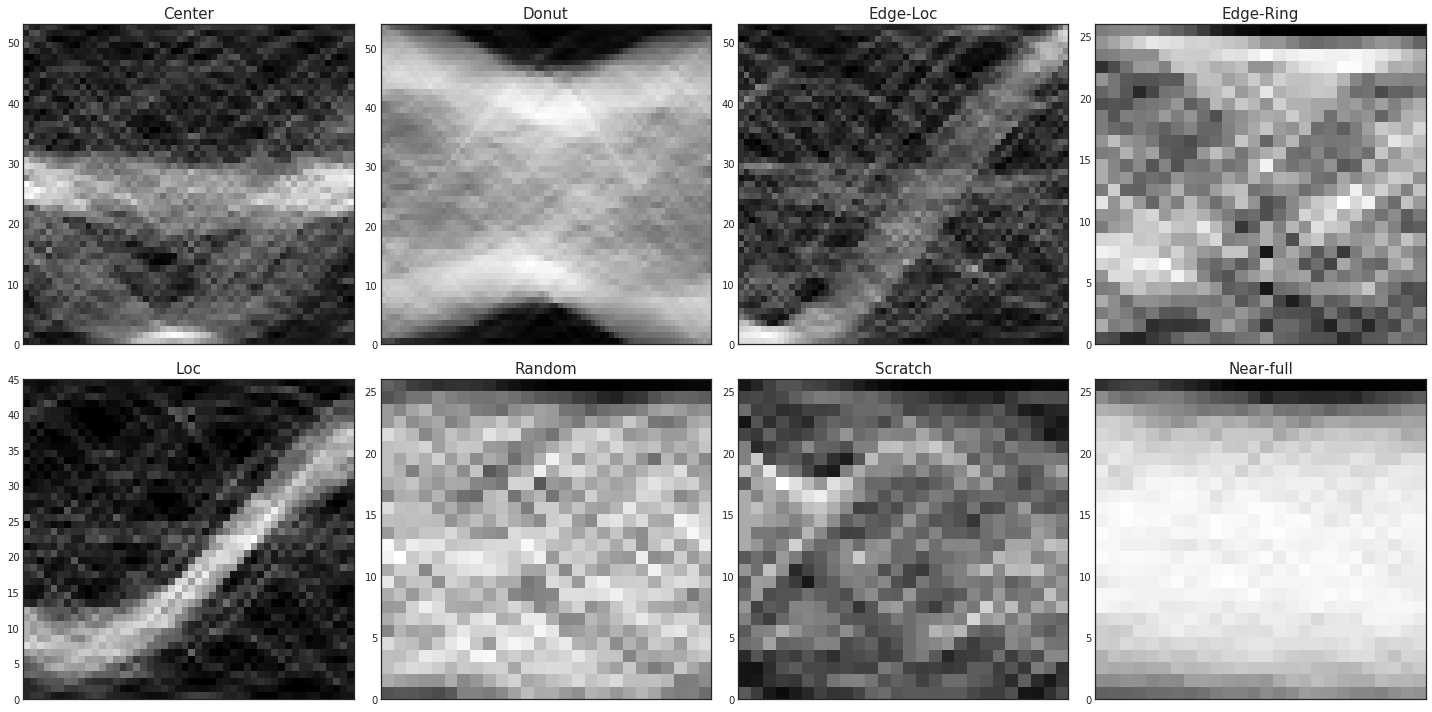

In [15]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

In [16]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [17]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

In [18]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [19]:
df_all=df_withpattern_copy.copy()

In [20]:
a = df_all.groupby('lotName').lotName.agg([('count', 'count')]).reset_index()

In [21]:
df_all = pd.merge(df_all, a, how = 'inner', on = 'lotName' )

In [22]:
#failer = pd.DataFrame({"fail_list":[[0.0204],[0.0513],[0.7621],[0.0102],[0.0167],[0.1248],[0],[0.0211],[0]],"failureNum":[0,1,2,3,4,5,6,7,8]})

In [23]:
b = pd.read_csv("./failer.csv")

In [24]:
b

,failureNum,fail_all,fail_etc,fail_only,fail_cycle
0,0,0.0023,0.3093,0.1626,0.0769
1,1,0.0029,0.0421,0.0161,0.0440
2,2,0.0073,0.2258,0.3339,0.4725
3,3,0.9728,0.2071,0.0745,0.2747
4,4,0.0040,0.1430,0.2494,0.1319
5,5,0.0003,0.0030,0.0133,0.0000
6,6,0.0104,0.0460,0.0415,0.0000
7,7,0.0000,0.0238,0.1086,0.0000
8,8,0.0000,0.0000,0.0000,0.0000


In [25]:
df_all = pd.merge(b, df_all, how = 'inner', on = 'failureNum' )

In [26]:
#failer = pd.DataFrame({"fail_list":[[0.0023,0.3093,0.1626,0.0769],[0.0029,0.0421,0.0161,0.044],[0.0073,0.2258,0.3339,0.4725],[0.9728,0.2071,0.0745,0.2747],[0.004,0.143,0.2494,0.1319],[0.0003,0.003,0.0133,0],[0.0104,0.046,0.0415,0],[0,0.0238,0.1086,0],[0,0,0,0]],"failureNum":[0,1,2,3,4,5,6,7,8]})

In [27]:
#df_all = pd.merge(failer, df_all, how = 'inner', on = 'failureNum' )

In [28]:
result = []
for i in df_all.index:
    a = [(x)*df_all.fail_all[i]/(26-df_all['count'][i]) for x in  df_all.fea_cir[i]]
    
    result.append(a)
df_all["fail_list_all"] = result      

In [29]:
result_a = []
for i in df_all.index:
    b = [(x)*df_all.fail_cycle[i]/(26-df_all['count'][i]) for x in  df_all.fea_reg[i]]
    
    result_a.append(b)
df_all["fail_list_cycle"] = result_a    

In [30]:
df_all_train = df_all[df_all.trianTestLabel == 'Training'].reset_index(drop=True)
df_all_test = df_all[df_all.trianTestLabel == 'Test'].reset_index(drop=True)

In [31]:
len(df_all_train)

17625

In [32]:
len(df_all_test)

7894

In [33]:
a=[df_all_train.fea_reg[i] for i in df_all_train.index] #13
b=[df_all_train.fea_cub_mean[i] for i in df_all_train.index] #20
c=[df_all_train.fea_cub_std[i] for i in df_all_train.index] #20
d=[df_all_train.fea_geom[i] for i in df_all_train.index] #6
e=[df_all_train.fail_list_all[i] for i in df_all_train.index] 
k=[df_all_train.fail_list_cycle[i] for i in df_all_train.index] 
#fea_all_train = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d),np.array(e),np.array(k)),axis=1)#63 in total
#fea_all_train = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(k)),axis=1)#63 in total
fea_all_train = np.concatenate((np.array(b),np.array(c),np.array(e),np.array(k)),axis=1)#63 in total

f=[df_all_test.fea_reg[i] for i in df_all_test.index] #13
g=[df_all_test.fea_cub_mean[i] for i in df_all_test.index] #20
h=[df_all_test.fea_cub_std[i] for i in df_all_test.index] #20
i=[df_all_test.fea_geom[i] for i in df_all_test.index] #6
j=[df_all_test.fail_list_all[i] for i in df_all_test.index] 
l=[df_all_test.fail_list_cycle[i] for i in df_all_test.index] 
#fea_all_test = np.concatenate((np.array(f),np.array(g),np.array(h),np.array(i),np.array(j),np.array(l)),axis=1)#63 in total
#fea_all_test = np.concatenate((np.array(f),np.array(g),np.array(h),np.array(l)),axis=1)#63 in total
fea_all_test = np.concatenate((np.array(g),np.array(h),np.array(j),np.array(l)),axis=1)#63 in total

In [34]:
label_train=[df_all_train.failureNum[i] for i in df_all_train.index]
label_train=np.array(label_train)

label_test=[df_all_test.failureNum[i] for i in df_all_test.index]
label_test=np.array(label_test)

#label=[df_all.failureNum[i] for i in df_all.index]
#label=np.array(label)

In [35]:
from sklearn.model_selection import train_test_split

X_train = fea_all_train
y_train = label_train
X_test = fea_all_test
y_test= label_test

#from collections import  Counter
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
#print('Training target statistics: {}'.format(Counter(y_train)))
#print('Testing target statistics: {}'.format(Counter(y_test)))

#RANDOM_STATE =42

In [36]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [37]:
"""
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE(ratio='auto', kind='regular')

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(X_test,list(y_test))

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))

"""

'\nfrom sklearn.datasets import make_classification\nfrom sklearn.decomposition import PCA\nfrom imblearn.over_sampling import SMOTE\n\n# 모델설정\nsm = SMOTE(ratio=\'auto\', kind=\'regular\')\n\n# train데이터를 넣어 복제함\nX_resampled, y_resampled = sm.fit_sample(X_test,list(y_test))\n\nprint(\'After OverSampling, the shape of train_X: {}\'.format(X_resampled.shape))\nprint(\'After OverSampling, the shape of train_y: {} \n\'.format(X_resampled.shape))\n\nprint("After OverSampling, counts of label \'1\': {}".format(sum(y_resampled==1)))\nprint("After OverSampling, counts of label \'0\': {}".format(sum(y_resampled==0)))\n\n'

In [38]:
#from collections import  Counter
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
#print('Training target statistics: {}'.format(Counter(y_train)))
#print('Testing target statistics: {}'.format(Counter(y_test)))

#RANDOM_STATE =42

In [39]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
k_fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [40]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

In [41]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
rf_param_grid = {"criterion":["gini"]}
gsRFC = GridSearchCV(RFC, rf_param_grid, cv=k_fold, scoring="accuracy",verbose=1)
gsRFC.fit(X_train, y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


0.9869503546099291

In [42]:
prediction = gsRFC.predict(X_test)
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.9184190524448949


In [43]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()

gb_param_grid = { "learning_rate":[0.1],
                 }
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=k_fold, scoring="accuracy",n_jobs=4,verbose=1)
gsGBC.fit(X_train, y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.4min finished


0.9889361702127659

In [44]:
prediction = gsGBC.predict(X_test)
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.9310869014441348


In [45]:
from sklearn.ensemble import AdaBoostClassifier
ABC = AdaBoostClassifier()
ab_param_grid = { "learning_rate":[0.1],
                 }
gsABC = GridSearchCV(ABC, param_grid=ab_param_grid, cv=k_fold, scoring="accuracy",n_jobs=4,verbose=1)
gsABC.fit(X_train, y_train)
ABC_best = gsRFC.best_estimator_
gsABC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.7s finished


0.16692198581560283

In [46]:
prediction = gsRFC.predict(X_test)
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.9184190524448949


In [47]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [50, 150] }
gsLR = GridSearchCV(LogisticRegression(penalty='l2'), param_grid=param_grid,cv=k_fold,  scoring="accuracy")
gsLR.fit(X_train, y_train)
LR_best = gsLR.best_estimator_
gsLR.best_score_

0.9830921985815603

In [48]:
prediction = gsLR.predict(X_test)
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.9174056245249557


In [49]:
from sklearn.svm import SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'], 'gamma':[0.001]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv = k_fold, scoring="accuracy",n_jobs=4,verbose=1)
gsSVMC.fit(X_train, y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.9min finished


0.7479716312056738

In [50]:
prediction = gsSVMC.predict(X_test)
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.3927033189764378


In [51]:
from xgboost.sklearn import  XGBClassifier
XGBC = XGBClassifier()
xgb_param_grid = {'learning_rate':[0.1]}
gsXGBC = GridSearchCV(XGBC,param_grid=xgb_param_grid, cv=k_fold, scoring="accuracy", n_jobs=1, verbose=1)

gsXGBC.fit(X_train, y_train)
XGBC_best = gsXGBC.best_estimator_
gsXGBC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished


0.9895602836879432

In [52]:
prediction = gsXGBC.predict(X_test)
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.9272865467443628


In [53]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best),('svc',SVMC_best),('gbc',GBC_best),('abc',ABC_best),('lr',LR_best),('xgb',XGBC_best)],voting='hard', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

prediction = votingC.predict(X_test)
prediction

array([0, 0, 0, ..., 7, 7, 7])

In [54]:
print('accuracy :' , accuracy_score(prediction, y_test))

accuracy : 0.9285533316442868


In [494]:
df_all_test['prediction'] = prediction

## lable과 pred틀린 case

In [495]:
result1 = df_all_test[df_all_test.failureNum != df_all_test.prediction][['lotName','waferIndex','failureType','failureNum', 'prediction']]
#{'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
result1

,lotName,waferIndex,failureType,failureNum,prediction
56,lot40797,23.0,[[Center]],0,4
66,lot40909,19.0,[[Center]],0,4
183,lot42675,9.0,[[Center]],0,4
188,lot42709,21.0,[[Center]],0,4
194,lot42724,15.0,[[Center]],0,4
...,...,...,...,...,...
7808,lot40869,1.0,[[Near-full]],7,5
7819,lot43599,24.0,[[Near-full]],7,5
7848,lot44251,7.0,[[Near-full]],7,5
7860,lot45425,23.0,[[Near-full]],7,5


In [496]:
result1.astype({'fail_pred' : 'int'}).dtypes

KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

In [497]:
result1['fail_pred'] = result1[['failureNum', 'prediction']].apply(lambda x: '&'.join(x.astype(str)), axis=1)

In [499]:
result1

,lotName,waferIndex,failureType,failureNum,prediction,fail_pred
56,lot40797,23.0,[[Center]],0,4,0&4
66,lot40909,19.0,[[Center]],0,4,0&4
183,lot42675,9.0,[[Center]],0,4,0&4
188,lot42709,21.0,[[Center]],0,4,0&4
194,lot42724,15.0,[[Center]],0,4,0&4
...,...,...,...,...,...,...
7808,lot40869,1.0,[[Near-full]],7,5,7&5
7819,lot43599,24.0,[[Near-full]],7,5,7&5
7848,lot44251,7.0,[[Near-full]],7,5,7&5
7860,lot45425,23.0,[[Near-full]],7,5,7&5


In [500]:
result1.to_csv("./result1.csv")

## MLPClassifier

In [109]:
import sklearn.datasets as datasets
import sklearn.model_selection as model_selection
import sklearn.neural_network as neural_network
import sklearn.preprocessing as preprocessing


mlpClassifier = neural_network.MLPClassifier(hidden_layer_sizes = (300, 300, 300), max_iter = 50, solver = "sgd", learning_rate_init = 0.01, verbose = True)
mlpClassifier.fit(X_train, y_train)
print("accuracy : %f" % mlpClassifier.score(X_test, y_test))

Iteration 1, loss = 2.11200952
Iteration 2, loss = 1.36693321
Iteration 3, loss = 1.23935769
Iteration 4, loss = 1.16546828
Iteration 5, loss = 1.10121796
Iteration 6, loss = 1.04291262
Iteration 7, loss = 0.98749377
Iteration 8, loss = 0.93572528
Iteration 9, loss = 0.88730814
Iteration 10, loss = 0.84126473
Iteration 11, loss = 0.79729622
Iteration 12, loss = 0.75630872
Iteration 13, loss = 0.71826008
Iteration 14, loss = 0.68289296
Iteration 15, loss = 0.64989483
Iteration 16, loss = 0.61915569
Iteration 17, loss = 0.59045467
Iteration 18, loss = 0.56410771
Iteration 19, loss = 0.53974161
Iteration 20, loss = 0.51708597
Iteration 21, loss = 0.49595855
Iteration 22, loss = 0.47629748
Iteration 23, loss = 0.45794416
Iteration 24, loss = 0.44091042
Iteration 25, loss = 0.42499337
Iteration 26, loss = 0.40985098
Iteration 27, loss = 0.39556545
Iteration 28, loss = 0.38224316
Iteration 29, loss = 0.36970336
Iteration 30, loss = 0.35778761
Iteration 31, loss = 0.34639864
Iteration 32, los

In [544]:
df_withlabel1 = df[(df['trianTestLabel']!='Training') & (df['trianTestLabel']!='Test')]
df_withlabel1 =df_withlabel1.reset_index()
df_withpattern1 = df[(df['trianTestLabel']!='Training') & (df['trianTestLabel']!='Test')]
df_withpattern1 = df_withpattern1.reset_index()
#df_nonpattern1 = df[(df['failureNum']==8)]
#df_withlabel1.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

In [546]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy1 = df_withpattern1.copy()
df_withpattern_copy1['new_waferMap'] =df_withpattern_copy1.waferMap.apply(change_val)

In [548]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [549]:
df_withpattern_copy1['fea_cub_mean'] =df_withpattern_copy1.waferMap.apply(cubic_inter_mean)
df_withpattern_copy1['fea_cub_std'] =df_withpattern_copy1.waferMap.apply(cubic_inter_std)

In [550]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy1['fea_geom'] =df_withpattern_copy1.waferMap.apply(fea_geom)

In [551]:
df_all1=df_withpattern_copy1.copy()

In [552]:
a1 = df_all1.groupby('lotName').lotName.agg([('count', 'count')]).reset_index()

In [553]:
df_all1 = pd.merge(df_all1, a1, how = 'inner', on = 'lotName' )

In [561]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)

   
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]


    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [562]:
df_all1['fea_reg']=df_all1.waferMap.apply(find_regions)

In [569]:
b1 = pd.read_csv("./failer.csv")

,failureNum,fail_all,fail_etc,fail_only,fail_cycle
0,0,0.0023,0.3093,0.1626,0.0769
1,1,0.0029,0.0421,0.0161,0.0440
2,2,0.0073,0.2258,0.3339,0.4725
3,3,0.9728,0.2071,0.0745,0.2747
4,4,0.0040,0.1430,0.2494,0.1319
5,5,0.0003,0.0030,0.0133,0.0000
6,6,0.0104,0.0460,0.0415,0.0000
7,7,0.0000,0.0238,0.1086,0.0000
8,8,0.0000,0.0000,0.0000,0.0000


In [555]:
#df_all1 = pd.merge(b1, df_all1, how = 'inner', on = 'failureNum' )

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [ ]:
'''
result = []
for i in df_all1.index:
    a = [(x)*df_all1.fail_all[i]/(26-df_all1['count'][i]) for x in  df_all1.fea_reg[i]]
    
    result.append(a)
df_all1["fail_list_all"] = result      
'''

In [ ]:
'''
result_a = []
for i in df_all1.index:
    b = [(x)*df_all1.fail_cycle[i]/(26-df_all1['count'][i]) for x in  df_all1.fea_reg[i]]
    
    result_a.append(b)
df_all1["fail_list_cycle"] = result_a    
'''

In [564]:
df_all_test1 = df_all1[df_all1.trianTestLabel != 'Test'].reset_index(drop=True)

In [565]:
f=[df_all_test1.fea_reg[i] for i in df_all_test1.index] #13
g=[df_all_test1.fea_cub_mean[i] for i in df_all_test1.index] #20
h=[df_all_test1.fea_cub_std[i] for i in df_all_test1.index] #20
i=[df_all_test1.fea_geom[i] for i in df_all_test1.index] #6
#j=[df_all_test1.fail_list_all[i] for i in df_all_test1.index] 
#l=[df_all_test1.fail_list_cycle[i] for i in df_all_test1.index] 
#fea_all_test = np.concatenate((np.array(f),np.array(g),np.array(h),np.array(i),np.array(j),np.array(l)),axis=1)#63 in total
fea_all_test1 = np.concatenate((np.array(f),np.array(g),np.array(h),np.array(i)),axis=1)#63 in total

In [566]:
from sklearn.model_selection import train_test_split

X_test1 = fea_all_test1

In [594]:
prediction1 = votingC.predict(X_test1)
prediction1

array([2, 0, 4, ..., 2, 2, 2])

In [595]:
df_all_test1['prediction'] = prediction1

In [599]:
result2 = df_all_test1[['lotName','waferIndex','failureType','failureNum', 'prediction']]
#{'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
result2

,lotName,waferIndex,failureType,failureNum,prediction
0,lot2,11.0,[],[],2
1,lot2,21.0,[],[],0
2,lot3,20.0,[],[],4
3,lot5,21.0,[],[],4
4,lot7,9.0,[],[],0
...,...,...,...,...,...
638502,lot47537,12.0,[],[],2
638503,lot47537,18.0,[],[],2
638504,lot47538,25.0,[],[],2
638505,lot47543,1.0,[],[],2


In [600]:
result2.to_csv("./result2.csv")

In [ ]:
df_all_test1.to_csv("./df_all_test1.csv")